In [1]:
import numpy as np
import dask
import dask.array as da
import os,sys
import pylab as pl
from scipy.integrate import quad

In [2]:
def read_model(filename):

    infile = open('../M10/'+filename,'r')

    fd=[];nS_all=[];nS_fsrq=[];nS_bll=[];nS_ss=[]
    while True:
        line = infile.readline()
        if not line: break

        if line[0]!='#':
            items = line.split()
            fd.append(10**(float(items[0])))
            nS_all.append(float(items[1]))
            
    fd = np.array(fd)
    SnS_all = np.array(nS_all)/fd**1.5
    
    return fd, SnS_all

In [3]:
def get_freq(filename):
    
    b = filename.find('_',4)
    e = filename.find('mhz')
    freq = filename[b+1:e]
    
    return freq

In [4]:
def logquad(func, a, b, **kwargs):

  """
  Perform scipy.integrate.quad more efficiently on a function that's better-behaved in log space.
  """

  # Perform integral $\int y dx$ by transforming variables x->log(x), y->log(y).

  return quad(lambda x,*args: np.exp(x + np.log(func(np.exp(x),*args))), np.log(a), np.log(b), **kwargs)

In [5]:
def polyfit(a):
    
    f = np.array(a[0])
    s = np.array(a[1])
    z = np.polyfit(np.log(f), np.log(s), 8)
    
    return z

In [6]:
def polyfunc(s,z):

    p = np.poly1d(z)
    
    return np.exp(p(np.log(s)))

In [7]:
def integrate(func, smin, smax, z):
    
    z = np.array(z)
    integral = logquad(func, smin, smax, args=(z))[0]
    
    return integral

In [8]:
infiles = os.listdir('../M10/')
print infiles

['m10_sf_ssb_multi.txt', 'm10_agn_325mhz.txt', 'm10_sf_ssb_325mhz.txt', 'm10_agn_1400mhz.txt', 'm10_sf_ps_325mhz.txt', 'm10_agn_610mhz.txt', 'm10_agn_408mhz.txt', 'm10_sf_ps_150mhz.txt', 'm10_sf_ssb_150mhz.txt', 'm10_agn_150mhz.txt', 'm10_sf_ps_multi.txt', 'm10_agn_4800mhz.txt']


In [9]:
agn_models = [f for f in infiles if f[0:7]=='m10_agn']
print agn_models

['m10_agn_325mhz.txt', 'm10_agn_1400mhz.txt', 'm10_agn_610mhz.txt', 'm10_agn_408mhz.txt', 'm10_agn_150mhz.txt', 'm10_agn_4800mhz.txt']


In [10]:
y = da.from_array(agn_models, chunks=(1))

In [11]:
rb=[];fr=[]
for x in y:
    # read in model data:
    a = dask.delayed(read_model)(x)
    
    # find frequency for each model:
    f = dask.delayed(get_freq)(x)
    
    # fit polynomial to each model:
    z = dask.delayed(polyfit)(a)
    
    # set limits and integrate:
    smin = 1e-6; smax = 1e2
    i = dask.delayed(integrate)(polyfunc,smin,smax,z)
    
    # put results into lists:
    rb.append(i)
    fr.append(f)
    
# convert lists to numpy arrays:
freq = dask.delayed(np.array)(fr)
egrb = dask.delayed(np.array)(rb)

In [12]:
def plot_egrb(x,a):
    
    freq = np.array([float(i) for i in x])
    f_srtd = np.sort(freq)
    
    temp = np.array(a);egrb=[]
    for f in f_srtd:
        egrb.append(temp[np.where(freq==f)])
        
    freq = f_srtd
    egrb = np.array(egrb)
    
    
    figname = "EGRB.png"
    
    # have to use ax object, not straight pl
    # because pl is not thread safe
    fig, ax = pl.subplots()
    
    ax.plot(freq,egrb)
    
    ax.set_xlabel(r"$\nu$ [MHz]")
    ax.set_ylabel(r"EGRB [Jy/sr]")
    ax.set_title(figname[:-4])
    ax.loglog()
    fig.savefig(figname)
    #pl.show()
    
    return figname

In [13]:
# plot integrated egrb against frequency:
fname = dask.delayed(plot_egrb)(freq, egrb)

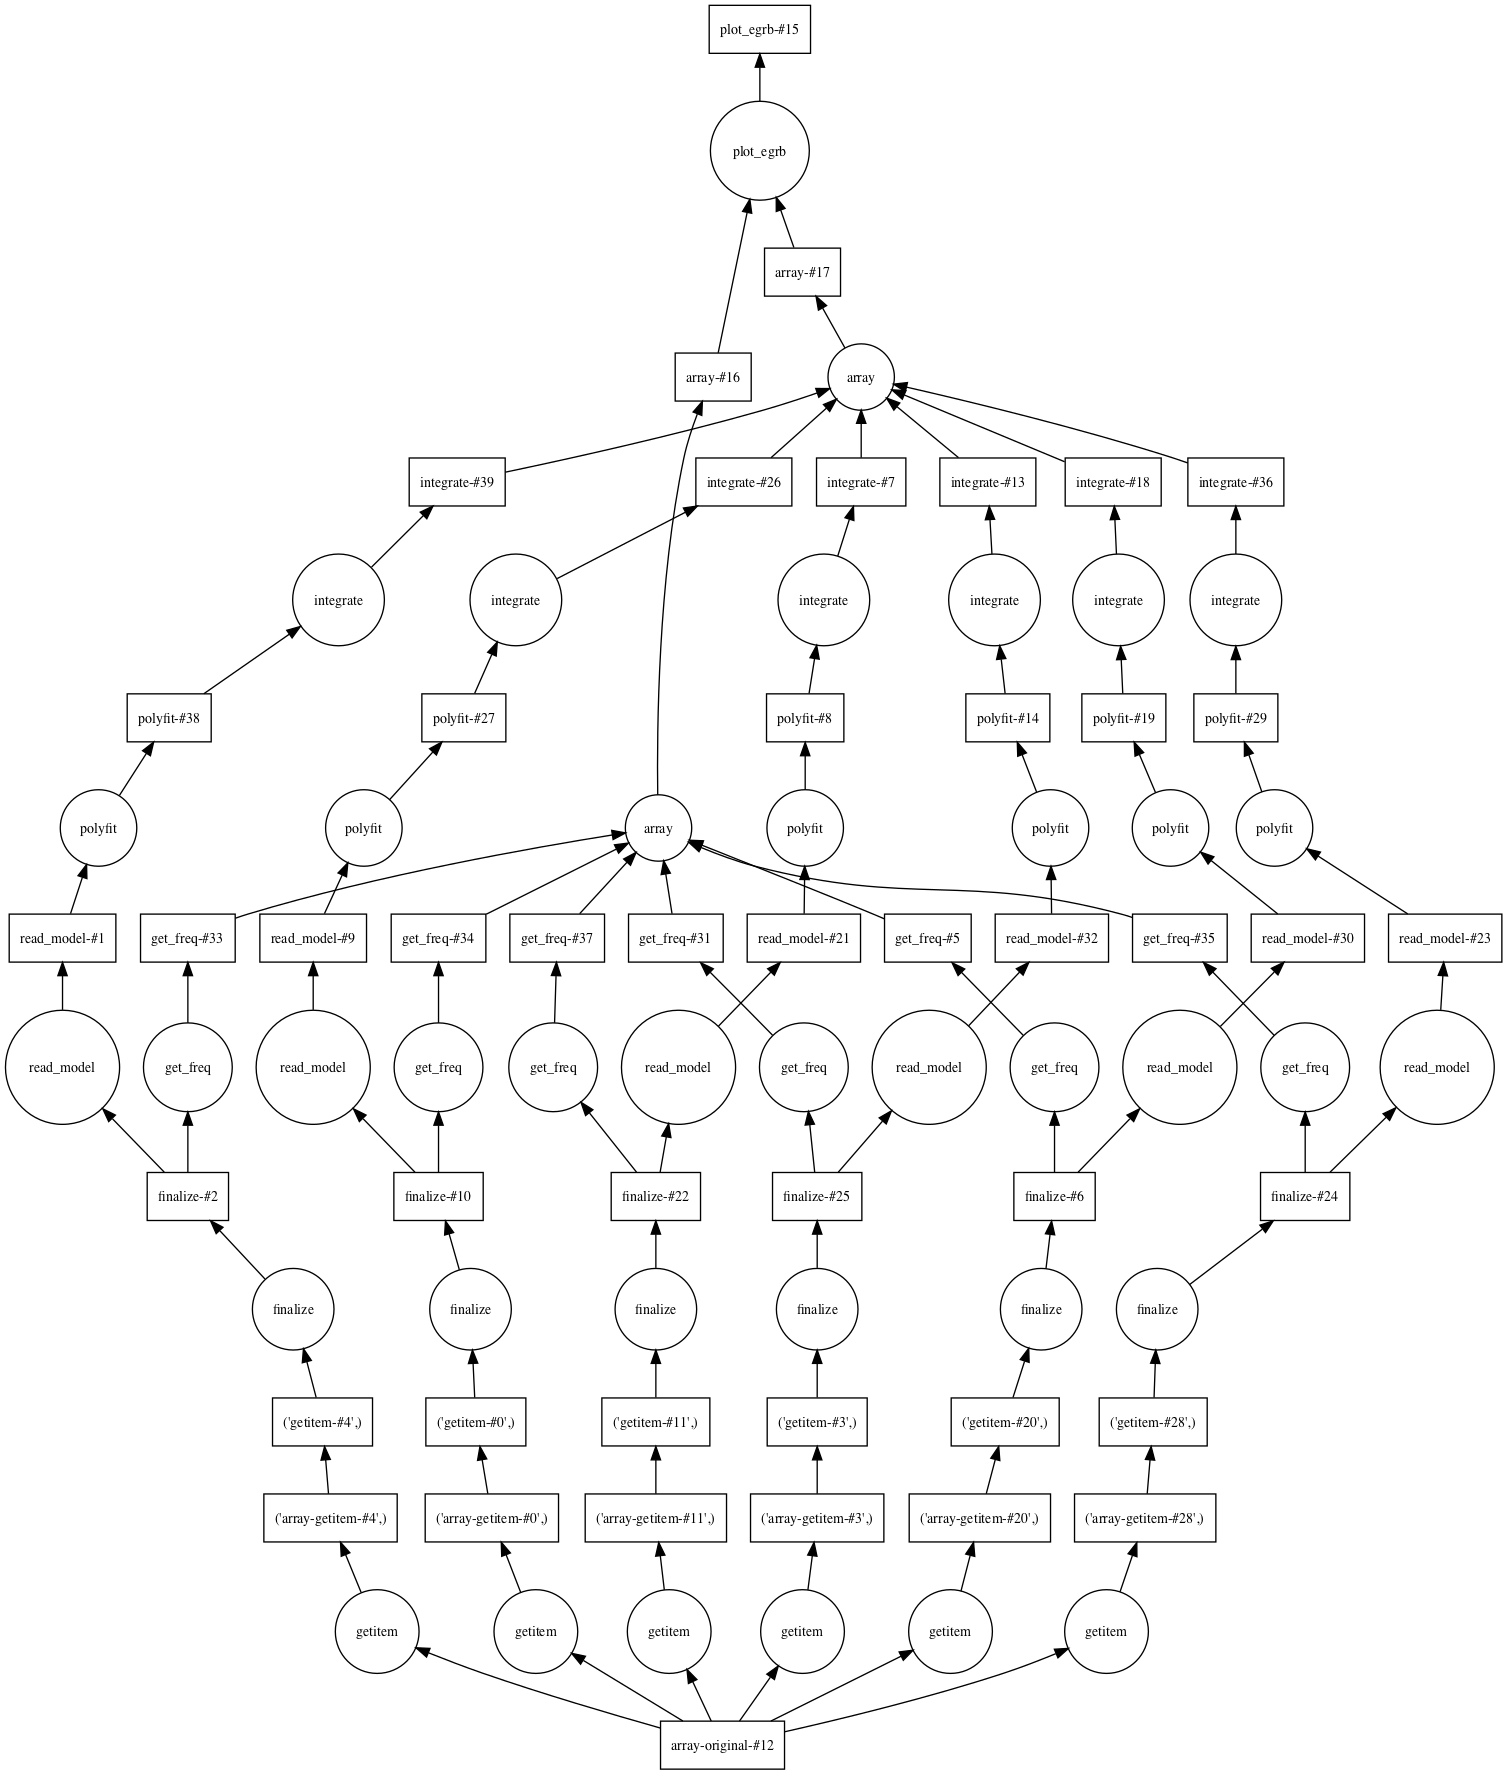

In [14]:
fname.visualize()

CPU times: user 173 ms, sys: 25.6 ms, total: 198 ms
Wall time: 214 ms


'EGRB.png'

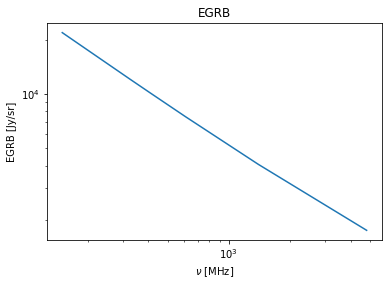

In [16]:
%%time
fname.compute()